In [6]:
# import required libraries

import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Create image generator
image_generator = ImageDataGenerator(
    rescale=1. / 255
)

In [228]:
# Train, validation and test sets
trainset = image_generator.flow_from_directory(
    os.path.join("swissroads", "train"),
    target_size=(224, 224),
    batch_size=32,
    shuffle=False # just for first tasks
)

validset = image_generator.flow_from_directory(
    os.path.join("swissroads", "valid"),
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

testset = image_generator.flow_from_directory(
    os.path.join("swissroads", "test"), 
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [3]:
# review class indices within trainset
trainset.class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

In [230]:
# split batch into images and labels and review shapes
batch_imgs, batch_labels = trainset.next()

print("Batch images:", batch_imgs.shape)
print("Batch labels:", batch_labels.shape)

Batch images: (32, 224, 224, 3)
Batch labels: (32, 6)


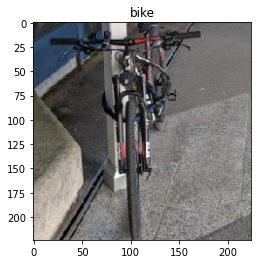

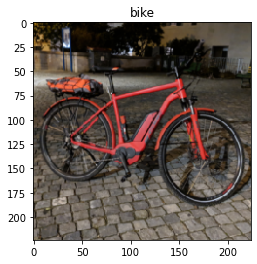

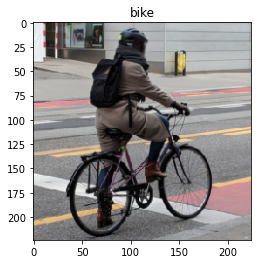

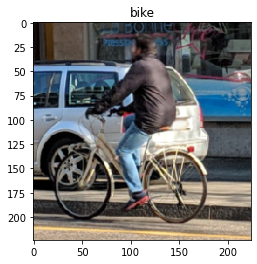

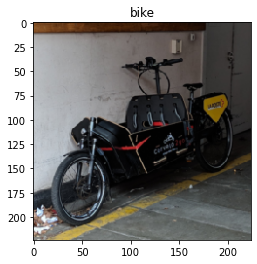

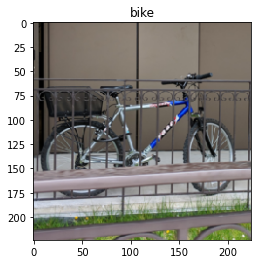

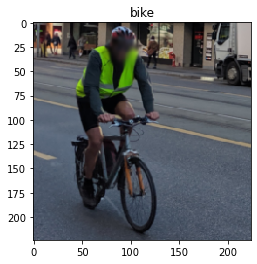

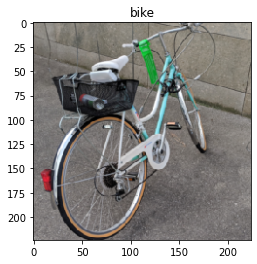

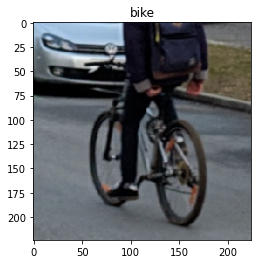

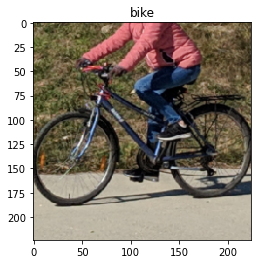

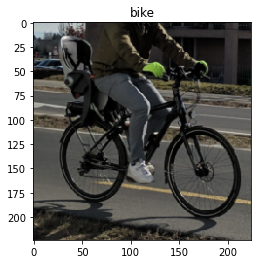

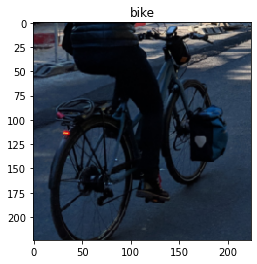

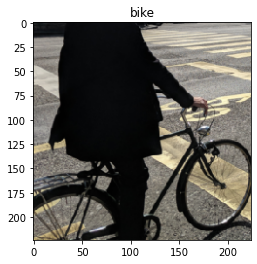

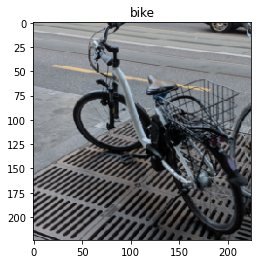

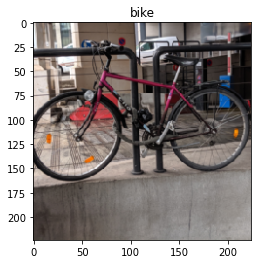

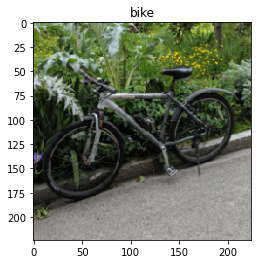

In [231]:
# create list of labels to map images to
class_labels = list(trainset.class_indices.keys())

# print images of each class within first batch of trainset
for i in range(16):
    label = batch_labels[i].argmax()   # argmax() returns position within array to use to map from class_labels
    plt.imshow(batch_imgs[i]),
    plt.title(class_labels[label]),
    plt.show()

In [57]:
train_data_counts = []

for label in class_labels:
    count = 0
    for file in trainset.filenames:
        if label in file:
            count = count+1
            
    train_data_counts.append(count)
    
valid_data_counts = []

for label in class_labels:
    count = 0
    for file in validset.filenames:
        if label in file:
            count = count+1
            
    valid_data_counts.append(count)
    
test_data_counts = []

for label in class_labels:
    count = 0
    for file in testset.filenames:
        if label in file:
            count = count+1
            
    test_data_counts.append(count)

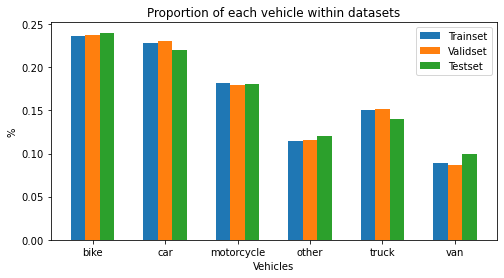

In [80]:
# plot graph to show proportion of vehicles within each dataset

# define values for each axis
x = class_labels
y1 = np.array(train_data_counts)/len(trainset.filenames)
y2 = np.array(valid_data_counts)/len(validset.filenames)
y3 = np.array(test_data_counts)/len(testset.filenames)

# set positions on x axis
x_pos = np.arange(len(x))
bar_width = 0.20

# plot data
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(x_pos, y1, bar_width, label='Trainset')
ax.bar(x_pos + bar_width, y2, bar_width, label='Validset')
ax.bar(x_pos + 2*bar_width, y3, bar_width, label='Testset')

ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(x)
ax.set_xlabel('Vehicles')
ax.set_ylabel('%')
ax.set_title('Proportion of each vehicle within datasets')
ax.legend()
plt.show()

Graph above shows clearly that datasets have been split well prooportionally.

*Plot color histogrm*

In [81]:
# ??????

In [84]:
# Create the image feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

feature_extractor = hub.load(model_url)

In [351]:
# extract features for train set
batch_imgs, batch_labels = trainset[0]
features_train_images = feature_extractor(batch_imgs)
train_labels = batch_labels

for i in range(1, (len(trainset.filenames)//32)+1):
    batch_imgs, batch_labels = trainset[i]
    train_labels = tf.concat([train_labels, batch_labels], axis=0)
    features_train_add = feature_extractor(batch_imgs)
    features_train_images = tf.concat([features_train_images, features_train_add], axis=0)

# save into npz file
np.savez("features_train.npz", features=features_train_images, labels=train_labels)


# extract features for validation set
batch_imgs, batch_labels = validset[0]
features_valid_images = feature_extractor(batch_imgs)
valid_labels = batch_labels

for i in range(1, (len(validset.filenames)//32)+1):
    batch_imgs, batch_labels = validset[i]
    valid_labels = tf.concat([valid_labels, batch_labels], axis=0)
    features_valid_add = feature_extractor(batch_imgs)
    features_valid_images = tf.concat([features_valid_images, features_valid_add], axis=0)

# save into npz file
np.savez("features_valid.npz", features=features_valid_images, labels=valid_labels)


# extract features for test set
batch_imgs, batch_labels = testset[0]
features_test_images = feature_extractor(batch_imgs)
test_labels = batch_labels

for i in range(1, (len(testset.filenames)//32)+1):
    batch_imgs, batch_labels = testset[i]
    test_labels = tf.concat([test_labels, batch_labels], axis=0)
    features_test_add = feature_extractor(batch_imgs)
    features_test_images = tf.concat([features_test_images, features_test_add], axis=0)

# save into npz file
np.savez("features_test.npz", features=features_test_images, labels=test_labels)


In [210]:
print(train_data_counts)
print(trainset.class_indices)

[66, 64, 51, 32, 42, 25]
{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}


In [298]:
bike_features = features_train[0:66]
car_features = features_train[66:130]
motorcycle_features = features_train[130:181]
other_features = features_train[181:213]
truck_features = features_train[213:255]
van_features = features_train[255:]

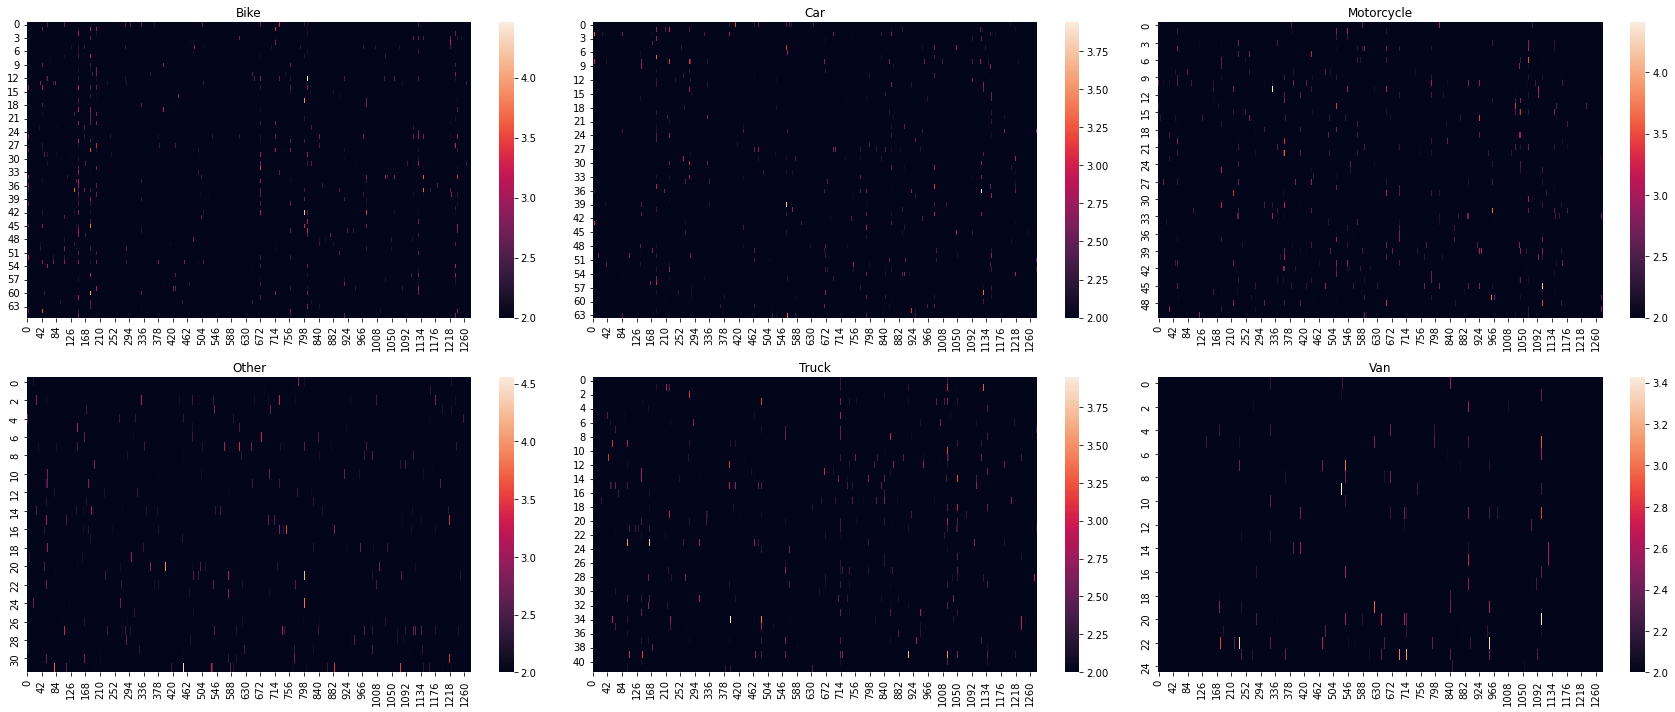

In [234]:
fig, ax = plt.subplots(2, 3, figsize=(24, 10))

sns.heatmap(bike, ax=ax[0, 0], vmin=2).set(title="Bike")
sns.heatmap(car, ax=ax[0, 1], vmin=2).set(title="Car")
sns.heatmap(motorcycle, ax=ax[0, 2], vmin=2).set(title="Motorcycle")
sns.heatmap(other, ax=ax[1, 0], vmin=2).set(title="Other")
sns.heatmap(truck, ax=ax[1, 1], vmin=2).set(title="Truck")
sns.heatmap(van, ax=ax[1, 2], vmin=2).set(title="Van")

plt.tight_layout()

In [223]:
trainset_images, trainset_labels = trainset[0]

for i in range(1, (len(trainset.filenames)//32)+1):
    batch_imgs, batch_labels = trainset[i]
    trainset_image_add = batch_imgs
    trainset_labels_add = batch_labels
    trainset_images = np.concatenate((trainset_images, trainset_image_add), axis=0)
    trainset_labels = np.concatenate((trainset_labels, trainset_labels_add), axis=0)
    

In [312]:
mean_values_bike = np.mean(bike_features, axis=0)
mean_values_car = np.mean(car_features, axis=0)
mean_values_motorcycle = np.mean(motorcycle_features, axis=0)
mean_values_other = np.mean(other_features, axis=0)
mean_values_truck = np.mean(truck_features, axis=0)
mean_values_van = np.mean(van_features, axis=0)

In [313]:
df_mean = pd.DataFrame(mean_values_bike)
df_mean = df_mean.rename(columns = {0: 'Bike'})
df_mean['Car'] = mean_values_car
df_mean['Motorcycle'] = mean_values_motorcycle
df_mean['Other'] = mean_values_other
df_mean['Truck'] = mean_values_truck
df_mean['Van'] = mean_values_van
df_mean = df_mean.sort_values('Truck', ascending=False)
df_mean

,Bike,Car,Motorcycle,Other,Truck,Van
1022,0.253878,0.460346,0.218406,1.013476,1.799956,1.852494
714,0.078448,0.225685,0.065716,0.796729,1.744271,1.433326
580,0.269270,0.868440,0.473164,1.080518,1.670997,0.966054
335,0.058068,0.163504,0.105821,0.613122,1.583188,0.611568
1051,0.048658,0.422416,0.050188,0.716368,1.522797,0.578220
...,...,...,...,...,...,...
686,0.161722,0.005769,0.022094,0.018233,0.003869,0.002833
533,0.382755,0.307994,0.026550,0.082927,0.003777,0.060616
325,0.006468,0.009971,0.033657,0.013795,0.003551,0.000095
99,0.034466,0.013973,0.028462,0.077241,0.001910,0.001893


In [322]:
df_mean = pd.DataFrame(mean_values_bike).sort_values(0, ascending=False)
df_mean = df_mean.reset_index().drop(0, axis=1)
df_mean = df_mean.rename(columns={'index': 'bike_mean'})
df_mean.head(5)

,bike_mean
0,54
1,1094
2,183
3,801
4,148


In [324]:
display(
    pd.DataFrame(mean_values_bike).sort_values(0, ascending=False).head(5),
    pd.DataFrame(mean_values_car).sort_values(0, ascending=False).head(5),
    pd.DataFrame(mean_values_motorcycle).sort_values(0, ascending=False).head(5),
    pd.DataFrame(mean_values_other).sort_values(0, ascending=False).head(5),
    pd.DataFrame(mean_values_truck).sort_values(0, ascending=False).head(5),
    pd.DataFrame(mean_values_van).sort_values(0, ascending=False).head(5)
)

,0
54,2.153599
1094,2.074225
183,1.961109
801,1.824539
148,1.819102


,0
257,1.828062
660,1.742579
183,1.674111
291,1.478164
1098,1.468120


,0
1120,1.904294
1122,1.834056
898,1.787201
505,1.686640
1043,1.627827


,0
411,1.291267
279,1.147639
734,1.140468
529,1.122214
580,1.080518


,0
1022,1.799956
714,1.744271
580,1.670997
335,1.583188
1051,1.522797


,0
1022,1.852494
1104,1.680597
1113,1.655889
466,1.560898
893,1.475819


Truck & Van share the most active feature (1022).

In [345]:
# retrain train set with shuffle
trainset = image_generator.flow_from_directory(
    os.path.join("swissroads", "train"),
    target_size=(224, 224),
    batch_size=32,
    shuffle=True 
)

Found 280 images belonging to 6 classes.
